In [83]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed # type: ignore
import numpy as np


np.random.seed(1)
tf.random.set_seed(1)

df = pd.read_csv('JNJ.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('1985-01-21 00:00:00'), Timestamp('2024-07-19 00:00:00'))

In [84]:
df.head()

,Date,Close
0,1985-01-21,2.367188
1,1985-01-22,2.343750
2,1985-01-23,2.375000
3,1985-01-24,2.335938
4,1985-01-25,2.304688


In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2020')
fig.show()

In [86]:
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']
train.shape, test.shape

((7216, 2), (2737, 2))

In [87]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/var/folders/rn/7_0zn04j3kg9chd3v9pymfm80000gp/T/ipykernel_15014/1980345901.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rn/7_0zn04j3kg9chd3v9pymfm80000gp/T/ipykernel_15014/1980345901.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (7186, 30, 1)
Testing shape: (2707, 30, 1)


In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

In [90]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
203/203 [==============================] - 9s 37ms/step - loss: 0.1346 - val_loss: 0.1647
Epoch 2/100
203/203 [==============================] - 7s 35ms/step - loss: 0.1095 - val_loss: 0.1698
Epoch 3/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0859 - val_loss: 0.1057
Epoch 4/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0787 - val_loss: 0.1115
Epoch 5/100
203/203 [==============================] - 7s 37ms/step - loss: 0.0771 - val_loss: 0.0962
Epoch 6/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0736 - val_loss: 0.0958
Epoch 7/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0736 - val_loss: 0.0953
Epoch 8/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0797 - val_loss: 0.0832
Epoch 9/100
203/203 [==============================] - 7s 36ms/step - loss: 0.0854 - val_loss: 0.0818
Epoch 10/100
203/203 [==============================] - 7s 36ms/step - loss: 0.091

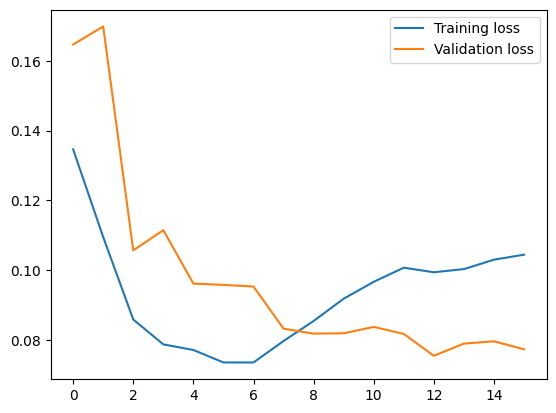

In [91]:
from matplotlib import pyplot as plt


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [92]:
model.evaluate(X_test, y_test)

85/85 [==============================] - 1s 10ms/step - loss: 1.2729


1.27289879322052

Reconstruction error threshold: 0.667139212516107


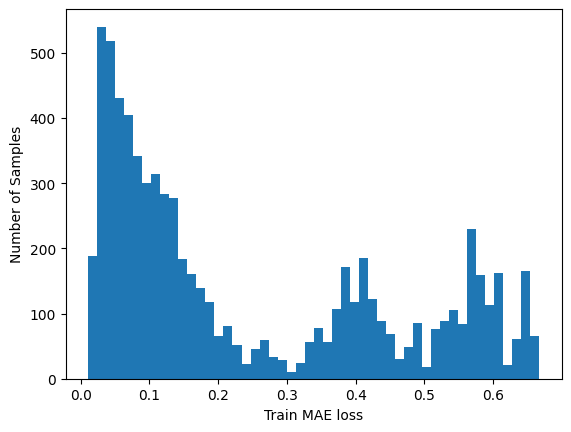

In [93]:

X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

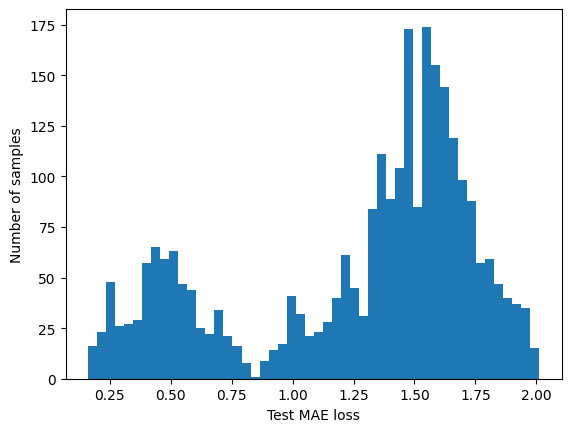

In [94]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [95]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [96]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(2168, 5)

In [97]:
import plotly.graph_objects as go

# Assuming test_score_df['Close'] and anomalies['Close'] are the arrays causing the issue
# Reshape the 'Close' columns to be 2D arrays
test_score_close_reshaped = test_score_df['Close'].values.reshape(-1, 1)
anomalies_close_reshaped = anomalies['Close'].values.reshape(-1, 1)

# Inverse transform the reshaped arrays
test_score_close_inverse = scaler.inverse_transform(test_score_close_reshaped).flatten()
anomalies_close_inverse = scaler.inverse_transform(anomalies_close_reshaped).flatten()

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_close_inverse, name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies_close_inverse, mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
